## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

##Load Data

### Unzip data

In [ ]:
from google.colab import drive
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file in Google Drive
zip_path = '/content/drive/MyDrive/ds340/project/data.zip'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/ds340/project/')

# Check the contents of the extracted directory
print(os.listdir('/content/drive/MyDrive/ds340/project/'))



### Assign datasets to variables

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
train_dir = '/content/drive/MyDrive/ds340/project/data/train'
valid_dir = '/content/drive/MyDrive/ds340/project/data/valid'
test_dir = '/content/drive/MyDrive/ds340/project/data/test'

print(os.listdir(test_dir))

['.DS_Store', 'Utility Knife', 'Folding Knife', 'Multi-tool Knife', 'Straight Knife', 'Scissor']


## Attempt 1: Multiclass Image Classification using CNN

In [11]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

In [12]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 3956 images belonging to 5 classes.


In [13]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(valid_dir,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 1415 images belonging to 5 classes.


In [14]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Folding Knife
1 : Multi-tool Knife
2 : Scissor
3 : Straight Knife
4 : Utility Knife


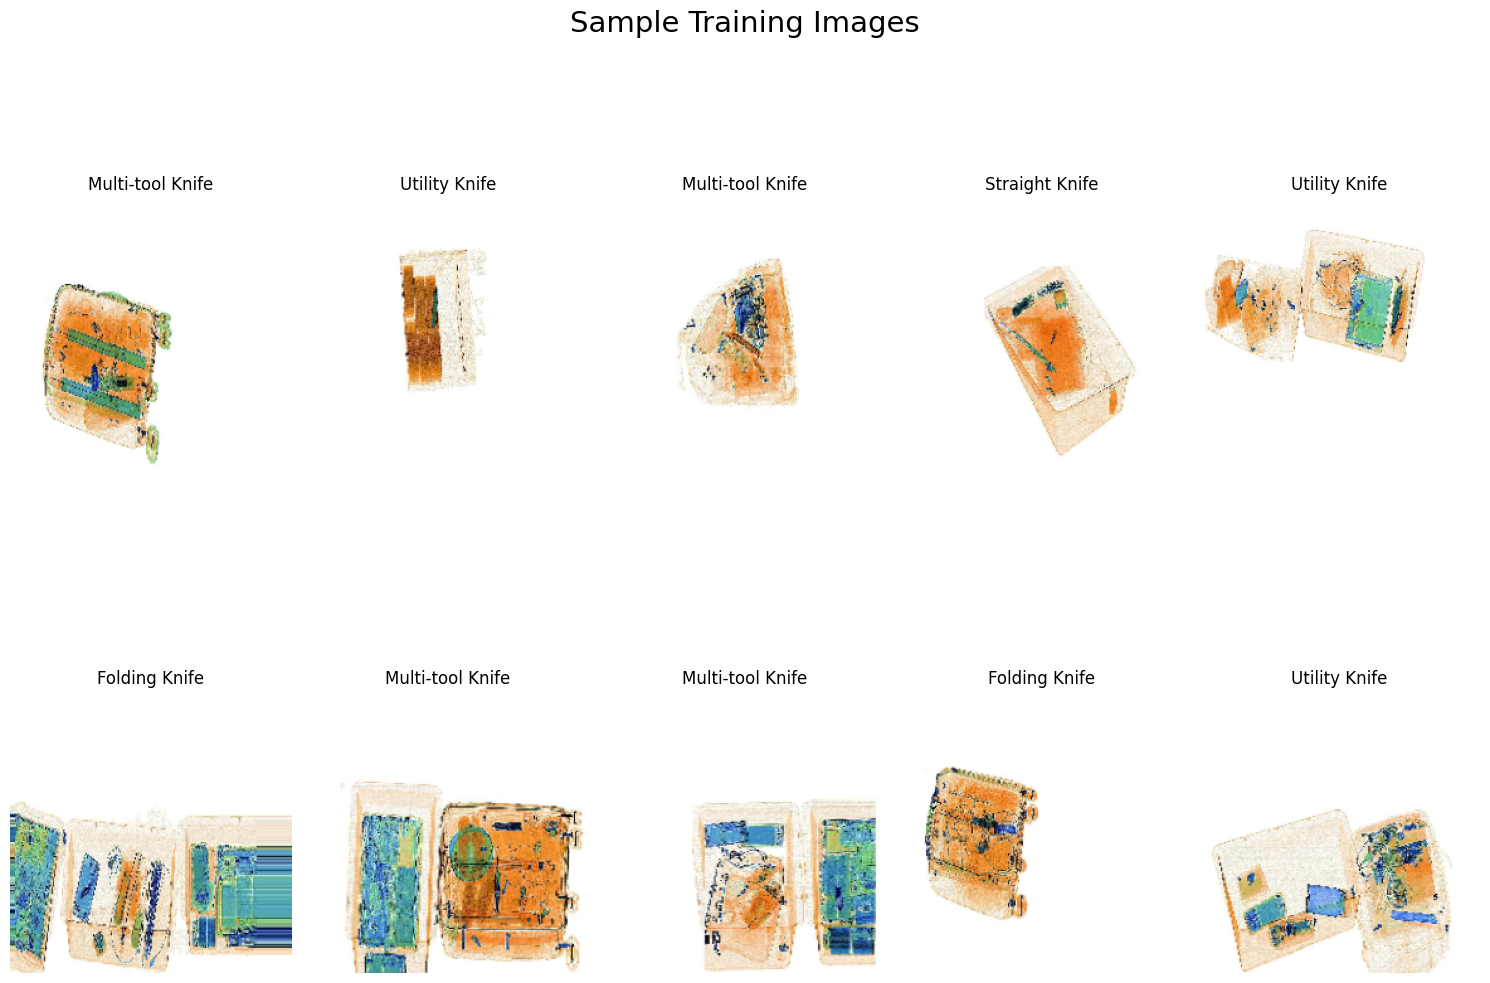

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()


^ There was an initial implementation up here that no longer works

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Adjusted to 224x224 for VGG16
    batch_size=20,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical'
)

Found 3956 images belonging to 5 classes.
Found 1415 images belonging to 5 classes.


In [18]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

In [19]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 3956 images belonging to 5 classes.


In [20]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(valid_dir,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)


Found 1415 images belonging to 5 classes.


In [21]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Folding Knife
1 : Multi-tool Knife
2 : Scissor
3 : Straight Knife
4 : Utility Knife


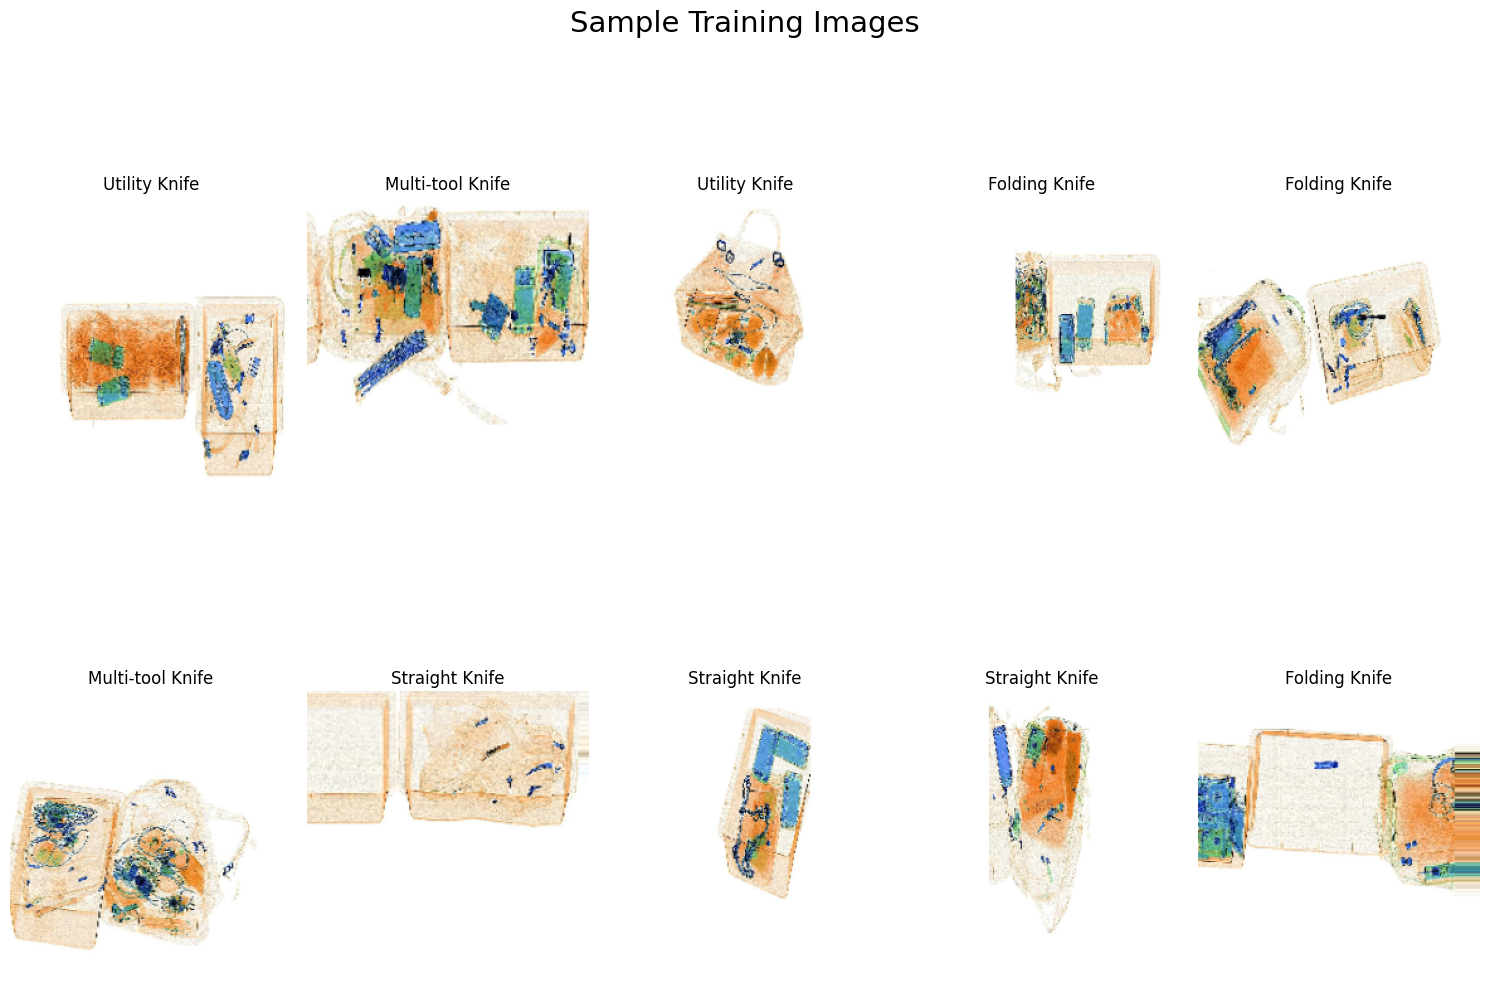

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()


In [23]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),

        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=5, activation='softmax')
    ])

    return model

In [24]:
cnn_model = create_model()

In [25]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 128)     9728      
                                                                 
 activation (Activation)     (None, 220, 220, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 128)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 110, 110, 128)     512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 64)      73792     
                                                                 
 activation_1 (Activation)   (None, 108, 108, 64)      0

In [26]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [27]:
optimizer = Adam(learning_rate=0.001)

In [28]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [29]:
history = cnn_model.fit(train_generator, epochs=10, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/10


KeyboardInterrupt: 

Gets stuck at Epoch 1/10

## Attempt 2

In [ ]:
image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3956 images belonging to 5 classes.
Found 1415 images belonging to 5 classes.
Found 707 images belonging to 5 classes.


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    verbose=2
)


Epoch 1/10


KeyboardInterrupt: 

Gets stuck at epoch 1/10 as well

## Attempt 3

In [ ]:
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // BATCH_SIZE
)

print(f"Test accuracy: {test_accuracy}")


17/22 [======================>.......] - ETA: 1:19 - loss: 2.7375 - accuracy: 0.2463

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [ ]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/10
100/100 [==============================] - 1713s 17s/step - loss: 1.5560 - accuracy: 0.2680 - val_loss: 2.0097 - val_accuracy: 0.2290
Epoch 2/10
  1/100 [..............................] - ETA: 19:31 - loss: 1.4415 - accuracy: 0.2000

KeyboardInterrupt: 

### Data Augmentation

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=25
)


Epoch 1/5
 5/50 [==>...........................] - ETA: 5:25 - loss: 2.3072 - accuracy: 0.1813

KeyboardInterrupt: 

### VGG16

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=30,
    epochs=3,
    validation_data=validation_generator,
    validation_steps=10
)


NameError: name 'train_datagen' is not defined

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical'
)


Found 3956 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=30,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=10,
    callbacks=[early_stopping]
)


Epoch 1/10
30/30 [==============================] - 63s 2s/step - loss: 1.5029 - accuracy: 0.3083 - val_loss: 1.7473 - val_accuracy: 0.3050
Epoch 2/10
30/30 [==============================] - 44s 1s/step - loss: 1.4515 - accuracy: 0.2917 - val_loss: 1.9016 - val_accuracy: 0.2100
Epoch 3/10
30/30 [==============================] - 42s 1s/step - loss: 1.4552 - accuracy: 0.2958 - val_loss: 1.8295 - val_accuracy: 0.1800
Epoch 4/10
30/30 [==============================] - 44s 1s/step - loss: 1.4373 - accuracy: 0.3112 - val_loss: 1.8558 - val_accuracy: 0.2000


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=30,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=10,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
30/30 [==============================] - 47s 1s/step - loss: 1.7778 - accuracy: 0.2753 - val_loss: 1.8794 - val_accuracy: 0.2250 - lr: 5.0000e-04
Epoch 2/20
30/30 [==============================] - 52s 2s/step - loss: 1.5965 - accuracy: 0.2722 - val_loss: 1.9461 - val_accuracy: 0.1800 - lr: 5.0000e-04
Epoch 3/20
30/30 [==============================] - 51s 2s/step - loss: 1.4672 - accuracy: 0.3027 - val_loss: 1.9760 - val_accuracy: 0.2750 - lr: 5.0000e-04
Epoch 4/20
30/30 [==============================] - 52s 2s/step - loss: 1.4528 - accuracy: 0.3021 - val_loss: 1.9951 - val_accuracy: 0.2100 - lr: 1.0000e-04
Epoch 5/20
30/30 [==============================] - 42s 1s/step - loss: 1.4449 - accuracy: 0.2792 - val_loss: 1.8676 - val_accuracy: 0.2350 - lr: 1.0000e-04
Epoch 6/20
30/30 [==============================] - 51s 2s/step - loss: 1.4206 - accuracy: 0.3027 - val_loss: 1.8758 - val_accuracy: 0.2400 - lr: 1.0000e-04
Epoch 7/20
30/30 [==============================] - 52s 2s

In [ ]:
image_size = (180, 180)
batch_size = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

model = models.Sequential([
    layers.Input(shape=(180, 180, 3)),
    layers.Rescaling(1.0 / 255),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 20
model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator
)


Found 3956 images belonging to 5 classes.
Found 1415 images belonging to 5 classes.
Epoch 1/20
124/124 [==============================] - 268s 2s/step - loss: 1.4249 - accuracy: 0.2776 - val_loss: 2.0189 - val_accuracy: 0.2311
Epoch 2/20
124/124 [==============================] - 241s 2s/step - loss: 1.4111 - accuracy: 0.2743 - val_loss: 1.9891 - val_accuracy: 0.2311
Epoch 3/20
124/124 [==============================] - 247s 2s/step - loss: 1.4078 - accuracy: 0.2813 - val_loss: 1.9021 - val_accuracy: 0.2254
Epoch 4/20
124/124 [==============================] - 238s 2s/step - loss: 1.4108 - accuracy: 0.2831 - val_loss: 1.9750 - val_accuracy: 0.2311
Epoch 5/20
124/124 [==============================] - 251s 2s/step - loss: 1.4062 - accuracy: 0.2930 - val_loss: 2.0215 - val_accuracy: 0.2332
Epoch 6/20
124/124 [==============================] - 248s 2s/step - loss: 1.4074 - accuracy: 0.2864 - val_loss: 1.9368 - val_accuracy: 0.2332
Epoch 7/20
124/124 [==============================] - 248s

## Resnet

###Libraries for Resnet

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/ds340/project/data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_val_datagen.flow_from_directory(
    '/content/drive/MyDrive/ds340/project/data/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_val_datagen.flow_from_directory(
    '/content/drive/MyDrive/ds340/project/data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 3956 images belonging to 5 classes.
Found 1415 images belonging to 5 classes.
Found 707 images belonging to 5 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/ds340/project/data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_val_datagen.flow_from_directory(
    '/content/drive/MyDrive/ds340/project/data/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_val_datagen.flow_from_directory(
    '/content/drive/MyDrive/ds340/project/data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

test_loss, test_acc = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)
print(f'Test accuracy: {test_acc}')

Found 3956 images belonging to 5 classes.
Found 1415 images belonging to 5 classes.
Found 707 images belonging to 5 classes.
Epoch 1/20
123/123 [==============================] - 631s 5s/step - loss: 1.6333 - accuracy: 0.2752 - val_loss: 2.0514 - val_accuracy: 0.2450
Epoch 2/20
123/123 [==============================] - 124s 1s/step - loss: 1.4112 - accuracy: 0.2979 - val_loss: 1.9186 - val_accuracy: 0.2351
Epoch 3/20
123/123 [==============================] - 125s 1s/step - loss: 1.4088 - accuracy: 0.2984 - val_loss: 2.0512 - val_accuracy: 0.2649
Epoch 4/20
123/123 [==============================] - 127s 1s/step - loss: 1.4093 - accuracy: 0.2949 - val_loss: 1.9987 - val_accuracy: 0.2585
Epoch 5/20
123/123 [==============================] - 125s 1s/step - loss: 1.4087 - accuracy: 0.3107 - val_loss: 2.0464 - val_accuracy: 0.2670
Epoch 6/20
123/123 [==============================] - 126s 1s/step - loss: 1.4002 - accuracy: 0.3191 - val_loss: 2.0306 - val_accuracy: 0.2699
Epoch 7/20
123/12

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#Unfreeze this time
for layer in base_model.layers[-23:]:
    layer.trainable = True


x = base_model.output
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)
#reduced batch size and epochs
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/ds340/project/data/train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

validation_generator = test_val_datagen.flow_from_directory(
    '/content/drive/MyDrive/ds340/project/data/valid',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_val_datagen.flow_from_directory(
    '/content/drive/MyDrive/ds340/project/data/test',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

test_loss, test_acc = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)
print(f'Test accuracy: {test_acc}')

Found 3956 images belonging to 5 classes.
Found 1415 images belonging to 5 classes.
Found 707 images belonging to 5 classes.
Epoch 1/10
247/247 [==============================] - 347s 1s/step - loss: 1.9412 - accuracy: 0.2777 - val_loss: 2.1723 - val_accuracy: 0.2436
Epoch 2/10
247/247 [==============================] - 304s 1s/step - loss: 1.4429 - accuracy: 0.2807 - val_loss: 2.3104 - val_accuracy: 0.2124
Epoch 3/10
247/247 [==============================] - 315s 1s/step - loss: 1.4298 - accuracy: 0.2741 - val_loss: 1.8478 - val_accuracy: 0.2259
Epoch 4/10
247/247 [==============================] - 306s 1s/step - loss: 1.4088 - accuracy: 0.2825 - val_loss: 1.9462 - val_accuracy: 0.2457
Epoch 5/10
247/247 [==============================] - 309s 1s/step - loss: 1.4095 - accuracy: 0.2713 - val_loss: 1.8596 - val_accuracy: 0.2422
Epoch 6/10
247/247 [==============================] - 310s 1s/step - loss: 1.4048 - accuracy: 0.2830 - val_loss: 2.1073 - val_accuracy: 0.2479
Epoch 7/10
125/24

KeyboardInterrupt: 

## Changes made:

*   reduced number of trainable params
*   increased dropout rate
*   early stopping (doubtful this will work)




In [ ]:
# Freeze more layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Reduce the number of trainable parameters
x = base_model.output
x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Increased dropout rate
predictions = Dense(5, activation='softmax')(x)


#smaller learning rate
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


#early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // train_generator.batch_size,
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // validation_generator.batch_size,
                    callbacks=[early_stopping])

Epoch 1/50
247/247 [==============================] - 137s 540ms/step - loss: 1.5523 - accuracy: 0.2794 - val_loss: 1.6082 - val_accuracy: 0.2251
Epoch 2/50
247/247 [==============================] - 133s 539ms/step - loss: 1.4447 - accuracy: 0.2670 - val_loss: 1.6141 - val_accuracy: 0.2244
Epoch 3/50
247/247 [==============================] - 134s 544ms/step - loss: 1.4258 - accuracy: 0.2716 - val_loss: 1.6293 - val_accuracy: 0.2337
Epoch 4/50
247/247 [==============================] - 133s 538ms/step - loss: 1.4206 - accuracy: 0.2876 - val_loss: 1.7370 - val_accuracy: 0.2464
Epoch 5/50
247/247 [==============================] - 135s 545ms/step - loss: 1.4162 - accuracy: 0.2850 - val_loss: 2.1144 - val_accuracy: 0.2308
Epoch 6/50
247/247 [==============================] - 134s 540ms/step - loss: 1.4147 - accuracy: 0.2891 - val_loss: 1.9416 - val_accuracy: 0.2301


# Using hyperparameters

In [7]:
def build_model(learning_rate, dropout_rate, optimizer):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(5, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [8]:
learning_rates = [0.001, 0.0001, 0.00001]
dropout_rates = [0.3, 0.5, 0.7]
optimizers = [tf.keras.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.SGD]


In [9]:
for learning_rate in learning_rates:
    for dropout_rate in dropout_rates:
        for optimizer_class in optimizers:
            optimizer = optimizer_class(learning_rate=learning_rate)
            model = build_model(learning_rate, dropout_rate, optimizer)

            history = model.fit(train_generator,
                                steps_per_epoch=train_generator.samples // train_generator.batch_size,
                                epochs=20,
                                validation_data=validation_generator,
                                validation_steps=validation_generator.samples // validation_generator.batch_size)

            val_loss, val_acc = model.evaluate(validation_generator,
                                               steps=validation_generator.samples // validation_generator.batch_size)

            print(f'Learning Rate: {learning_rate}, Dropout Rate: {dropout_rate}, Optimizer: {optimizer_class.__name__}')
            print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')
            print('-' * 50)

94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/20
 25/123 [=====>........................] - ETA: 16:59 - loss: 2.2803 - accuracy: 0.2728

KeyboardInterrupt: 

#### Qs
Ask about which hyperparameters work may work best.

Ask about run time type.

Ask if able to present Tuesday.